In [1]:
from calendar import monthrange
from datetime import datetime
import itertools

from netCDF4 import date2num, num2date
import numpy as np
from pyproj import Proj
from siphon.catalog import TDSCatalog
import xarray as xr

from matplotlib import pyplot as plt
import cartopy.crs as ccrs

import cartopy.feature as feat
import pandas as pd 

%matplotlib inline


In [49]:
era = xr.open_dataset('../data/_grib2netcdf-atls19-95e2cf679cd58ee9b4db4dd119a05a8d-sUCX6e.nc')
era.load()
era = xr.conventions.decode_cf(era, mask_and_scale=False)
era_lons = ((era.longitude + 180) % 360) - 180
era.longitude.data = era_lons
era = era.sortby(era.longitude)

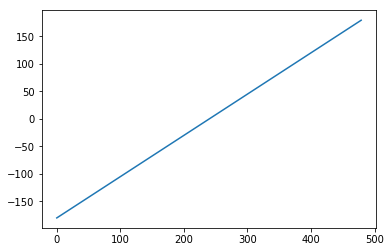

In [50]:
plt.plot(era.longitude)

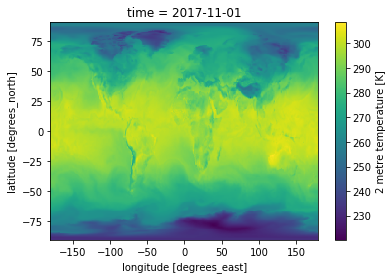

In [51]:
era.isel(time=0).t2m.plot.pcolormesh()

In [5]:
"""es.. so confirming: "We decided on Nov. 6 from 0600 to 2200 in 4 hour increments"
and "he grid will need to be 7 x 7. Using your maps, we think if you go from -77 to -70 longitude and increment the squares by 1 degree, and go from 40 to 45.25 latitude and increment by .75 degrees,"""

'es.. so confirming: "We decided on Nov. 6 from 0600 to 2200 in 4 hour increments"\nand "he grid will need to be 7 x 7. Using your maps, we think if you go from -77 to -70 longitude and increment the squares by 1 degree, and go from 40 to 45.25 latitude and increment by .75 degrees,'

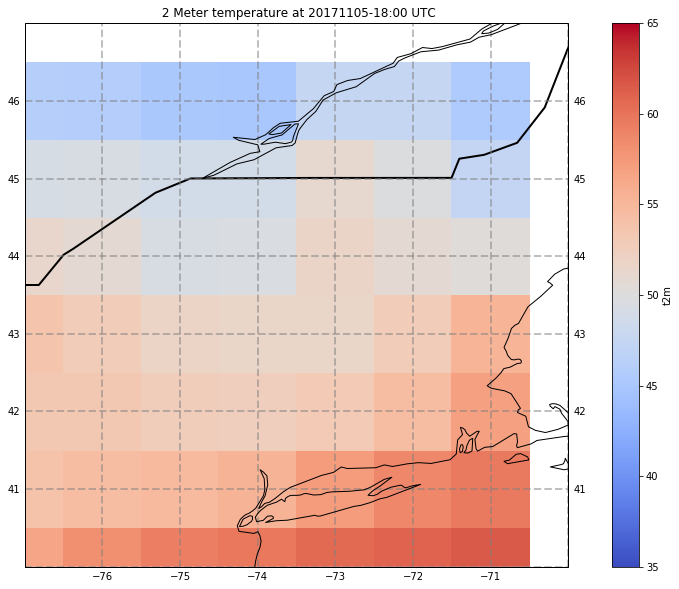

In [52]:
extent = (-70., -77., 40., 47.)
#points = [(35.25 , -97.1), (40, -105)]
points = [(extent[2] , extent[1]), (extent[3], extent[0])]
lats, lons = map(np.array, zip(*points))

subset = era.where((lons[0] <  era.longitude) & (era.longitude < lons[1]) & (lats[0] < era.latitude) & (era.latitude < lats[1]), drop=True)
#subset = era.sel(longitude=lons, latitude=lats, method='nearest')
myair = (subset.sel(time='2017-11-05T18:00:00', method='nearest').t2m.isel(time=0) - 273.15)*9./5. + 32.

block_lats = np.arange(extent[2],extent[3], 1)
block_lons = np.arange(extent[1],extent[0], 1)
foo = myair.reindex(indexers={'latitude' : block_lats, 'longitude' : block_lons},
                   method='nearest')

ts = pd.to_datetime(str(foo.time.data)) 
d = ts.strftime('../data/griddata-7b7-mass-%Y%m%d-%H%M.csv')

myfile = open(d, 'w')
myfile.write('lat,lon,temp2m\n')
for i in range(len(foo.latitude)):
    for j in range(len(foo.longitude)):
        strg = "{lat},{lon},{t2}\n"
        myfile.write( strg.format(lat=foo.latitude[i].data, 
                          lon=foo.longitude[j].data,
                         t2=foo[i,j].data))

myfile.close()

fig = plt.figure(figsize=(15.5, 10.))

proj = ccrs.PlateCarree()
ax = plt.axes(projection=proj)
foo.plot.pcolormesh(ax=ax, transform=proj,  vmin = 35, vmax = 65, cmap = 'coolwarm')

state_boundaries = feat.NaturalEarthFeature(category='cultural',
                                            name='admin_1_states_provinces_lines',
                                            scale='50m', facecolor='none')

ax.coastlines(resolution='50m', zorder=2, color='black')
ax.add_feature(state_boundaries)
ax.add_feature(feat.BORDERS, linewidth=2, edgecolor='black')
ax.set_extent(extent)
gl = ax.gridlines(crs=proj, draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False

#plt.tight_layout()
title = ts.strftime(' 2 Meter temperature at %Y%m%d-%H:%M UTC')
plt.title(title)
imd = ts.strftime('../images/griddata-mass-%Y%m%d-%H%M.jpg')
plt.savefig(imd)

# interpolation

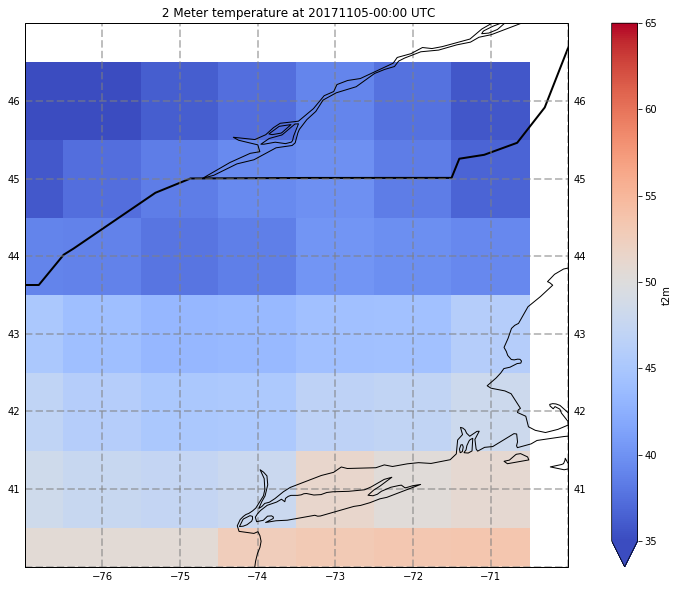

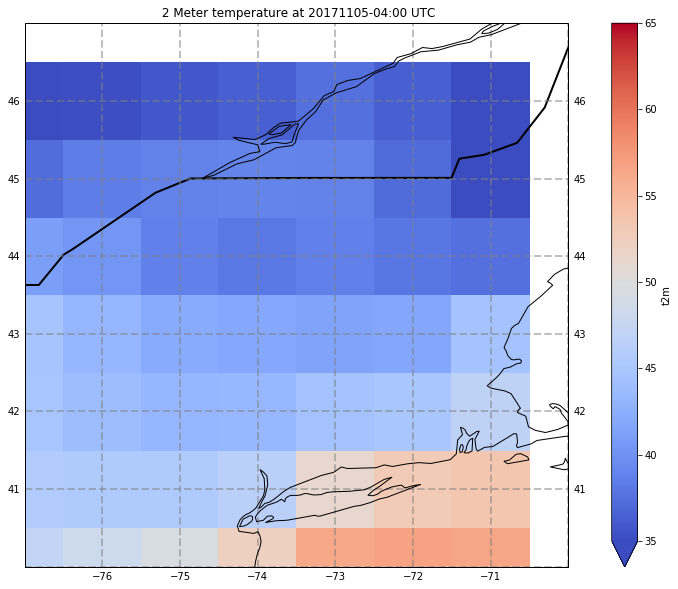

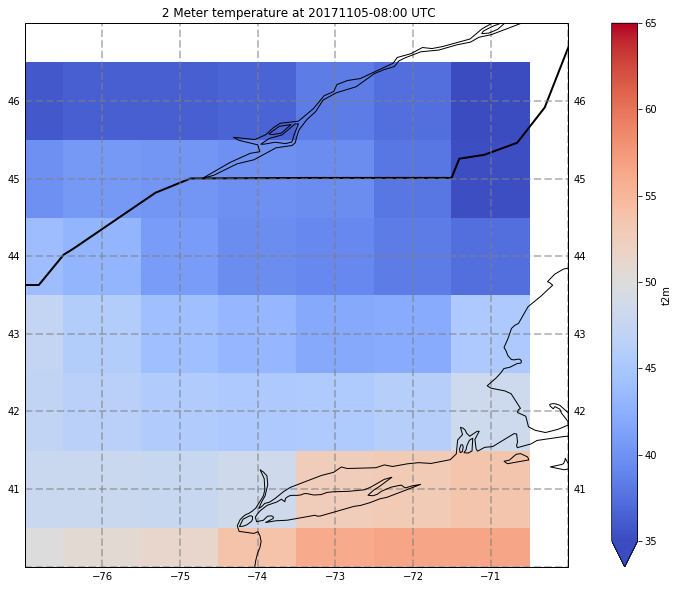

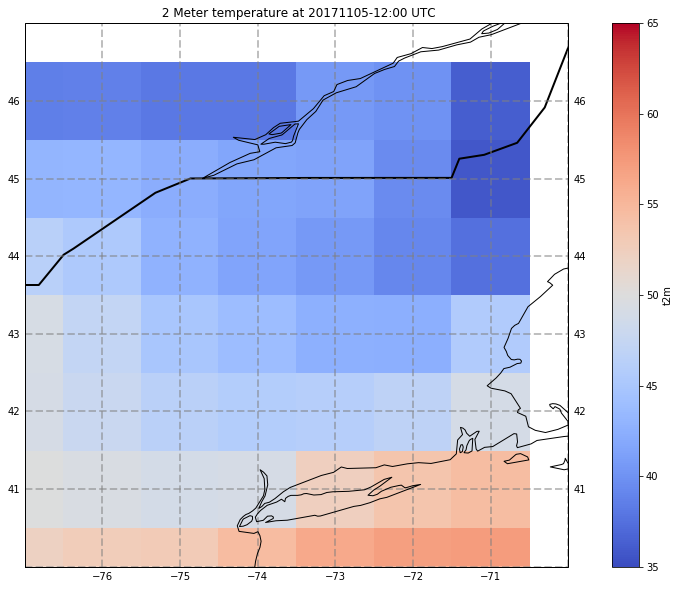

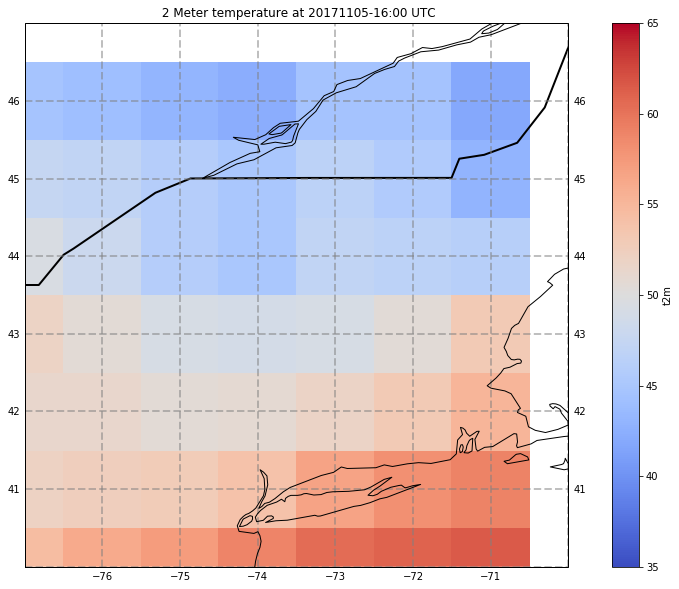

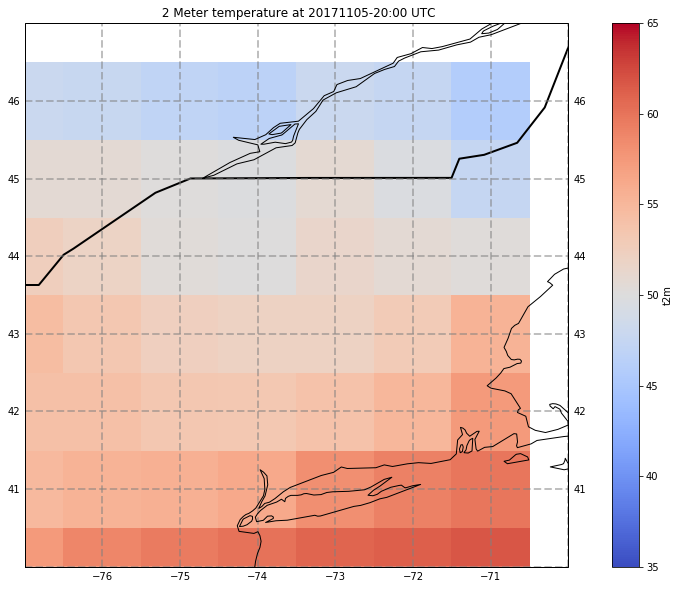

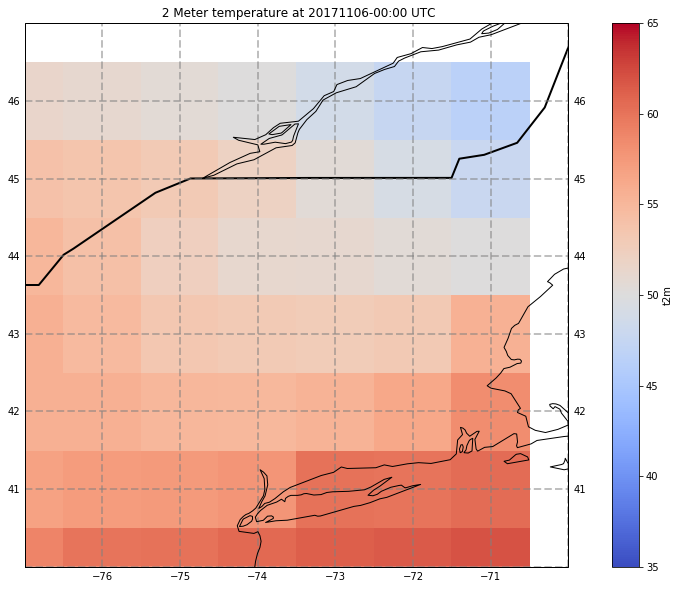

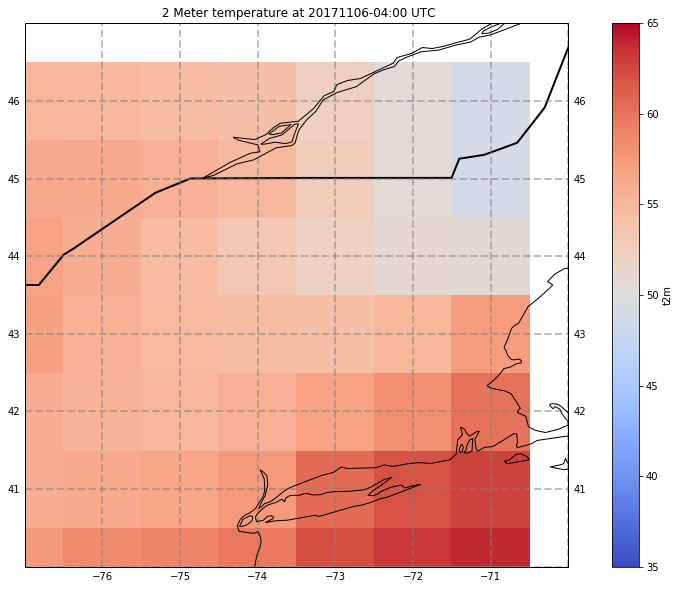

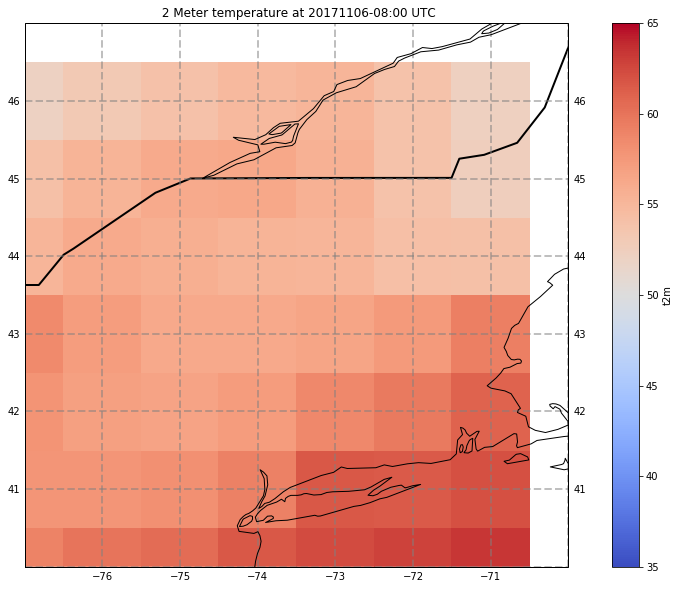

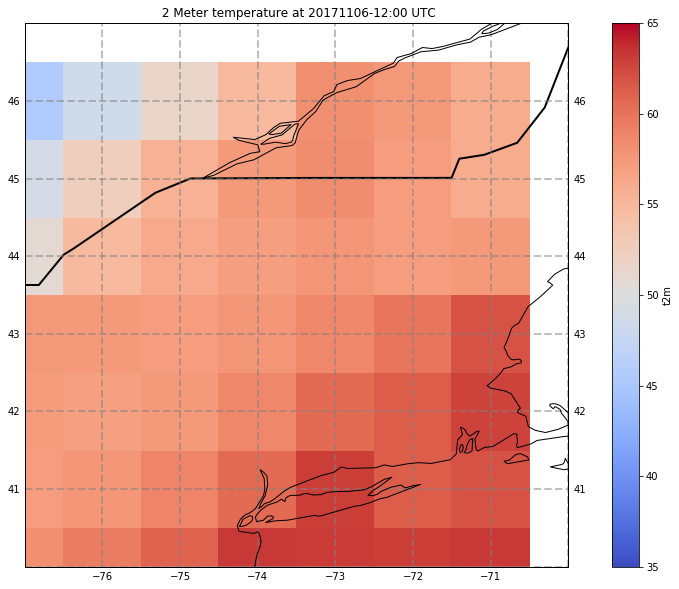

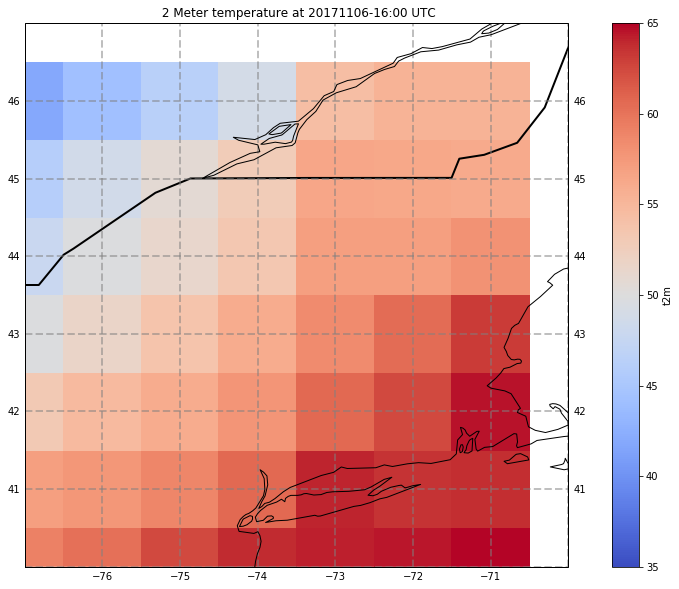

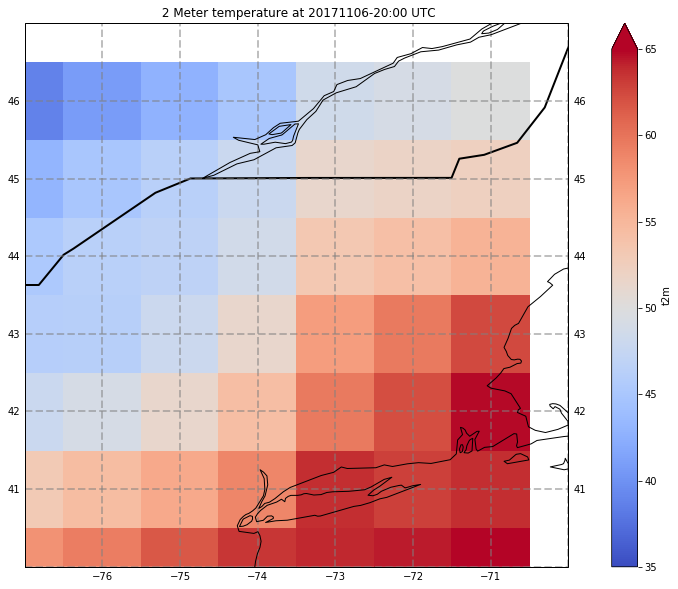

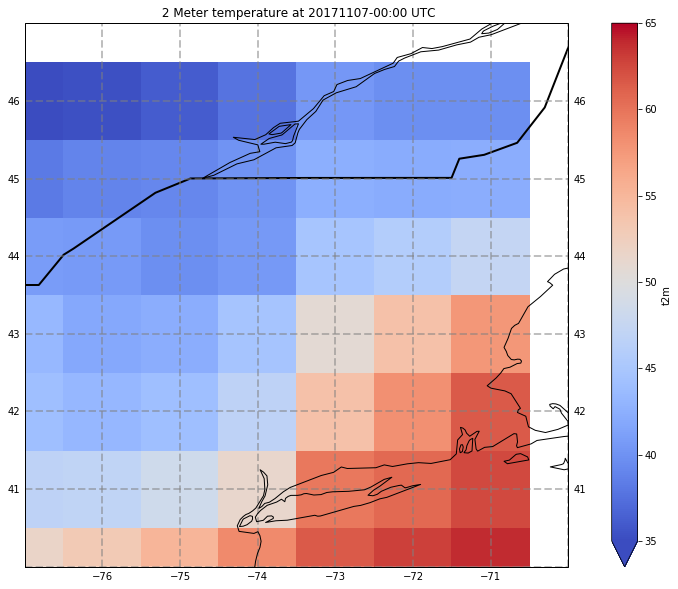

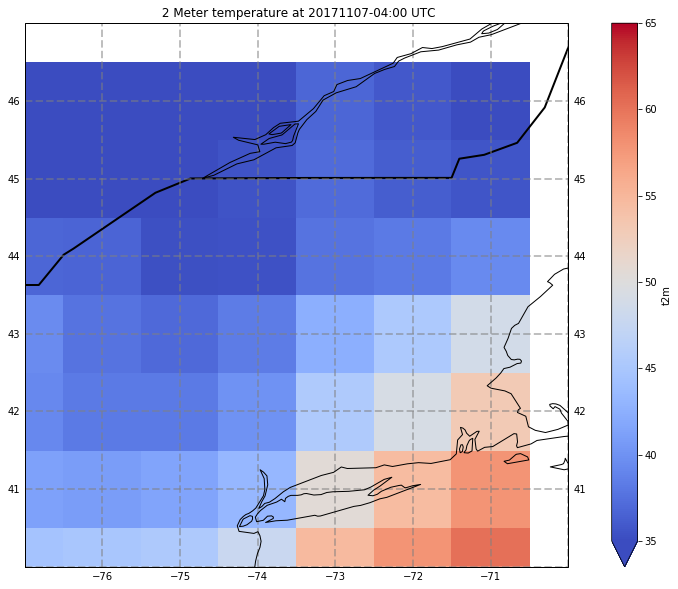

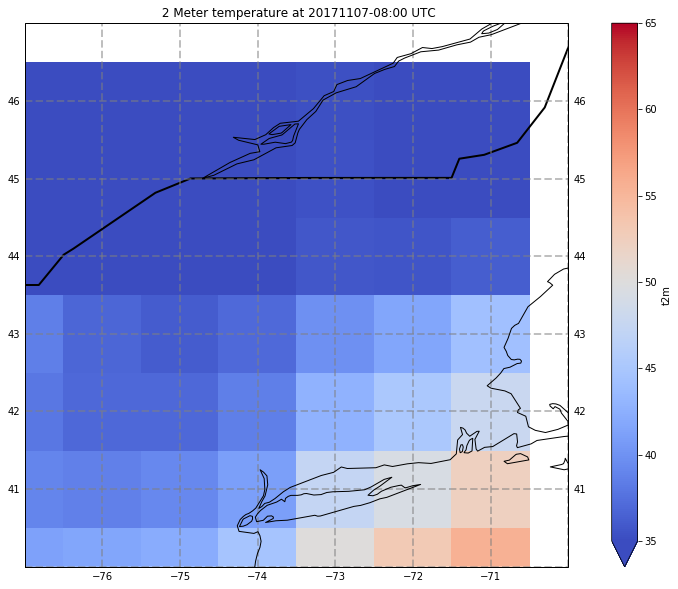

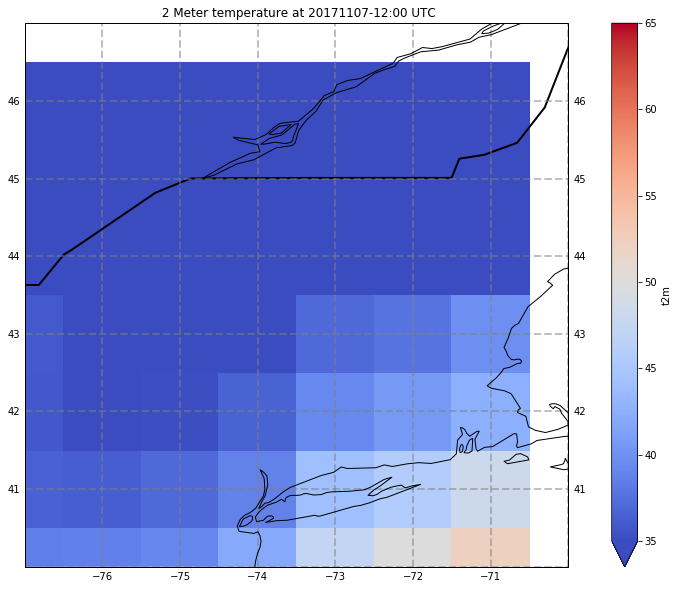

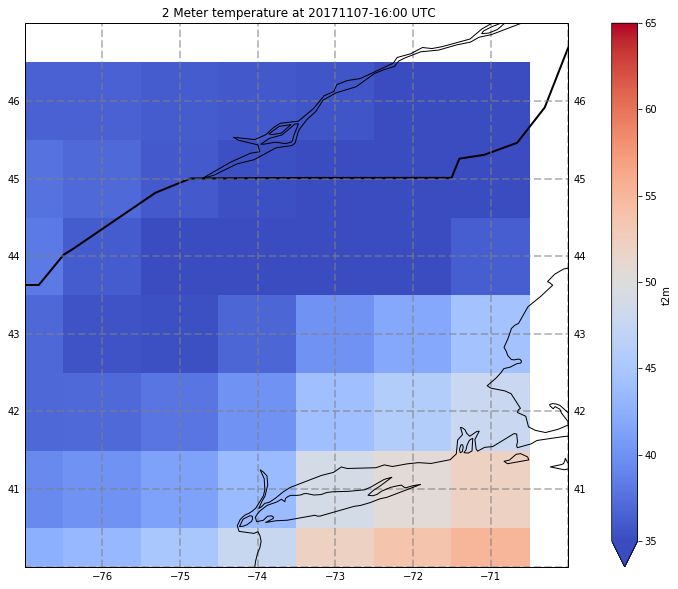

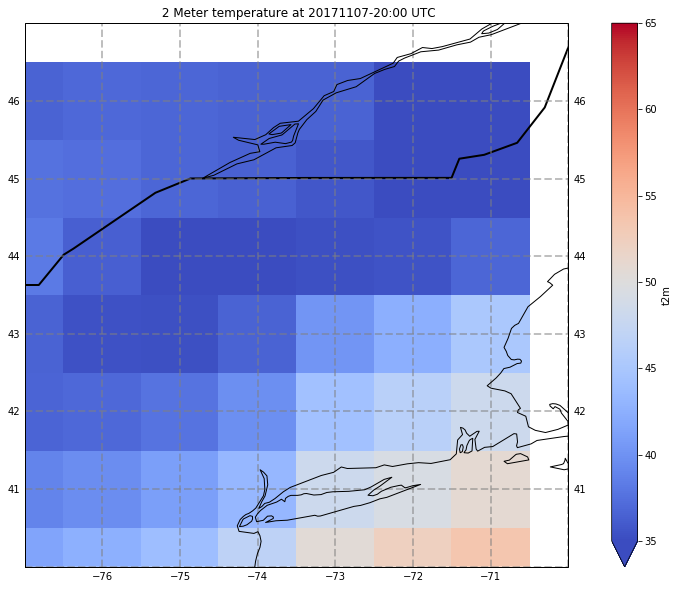

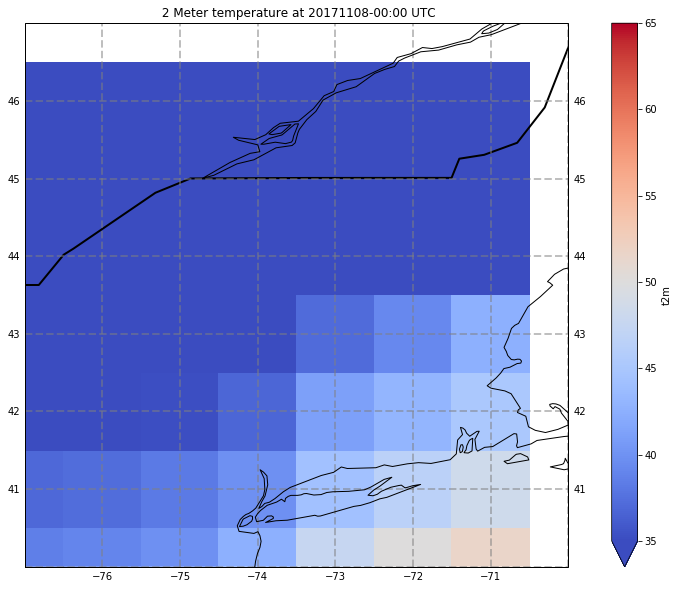

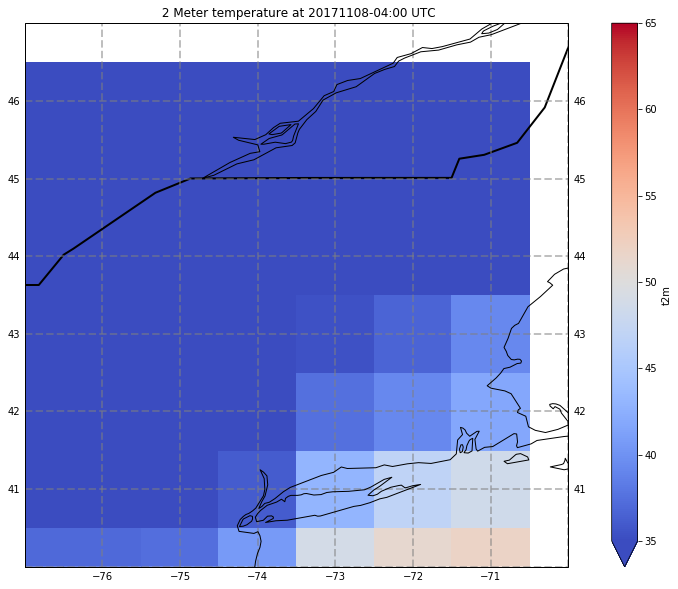

In [62]:
for this_time in pd.date_range('2017-11-05', freq='4H', periods=20):
    itime = pd.date_range('2017-11-05', freq='4H', periods=20)
    extent = (-70., -77., 40., 47.)
    #points = [(35.25 , -97.1), (40, -105)]
    points = [(extent[2] , extent[1]), (extent[3], extent[0])]
    lats, lons = map(np.array, zip(*points))
    interp_era = era.interp(coords={'time': itime})
    subset = interp_era.where((lons[0] <  interp_era.longitude) & (interp_era.longitude < lons[1]) & (lats[0] < interp_era.latitude) & (era.latitude < lats[1]), drop=True)
    #subset = era.sel(longitude=lons, latitude=lats, method='nearest')
    myair = (subset.sel(time=this_time, method='nearest').t2m - 273.15)*9./5. + 32.

    block_lats = np.arange(extent[2],extent[3], 1)
    block_lons = np.arange(extent[1],extent[0], 1)
    foo = myair.reindex(indexers={'latitude' : block_lats, 'longitude' : block_lons},
                       method='nearest')

    ts = pd.to_datetime(str(foo.time.data)) 
    d = ts.strftime('../data/griddata-interp-7b7-mass-%Y%m%d-%H%M.csv')

    myfile = open(d, 'w')
    myfile.write('lat,lon,temp2m\n')
    for i in range(len(foo.latitude)):
        for j in range(len(foo.longitude)):
            strg = "{lat},{lon},{t2}\n"
            myfile.write( strg.format(lat=foo.latitude[i].data, 
                              lon=foo.longitude[j].data,
                             t2=foo[i,j].data))

    myfile.close()

    fig = plt.figure(figsize=(15.5, 10.))

    proj = ccrs.PlateCarree()
    ax = plt.axes(projection=proj)
    foo.plot.pcolormesh(ax=ax, transform=proj,  vmin = 35, vmax = 65, cmap = 'coolwarm')

    state_boundaries = feat.NaturalEarthFeature(category='cultural',
                                                name='admin_1_states_provinces_lines',
                                                scale='50m', facecolor='none')

    ax.coastlines(resolution='50m', zorder=2, color='black')
    ax.add_feature(state_boundaries)
    ax.add_feature(feat.BORDERS, linewidth=2, edgecolor='black')
    ax.set_extent(extent)
    gl = ax.gridlines(crs=proj, draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False

    #plt.tight_layout()
    title = ts.strftime(' 2 Meter temperature at %Y%m%d-%H:%M UTC')
    plt.title(title)
    imd = ts.strftime('../images/griddata-interp-mass-%Y%m%d-%H%M.jpg')
    plt.savefig(imd)

In [60]:
interp_era.time

<xarray.DataArray 'time' (time: 10)>
array(['2017-11-05T00:00:00.000000000', '2017-11-05T04:00:00.000000000',
       '2017-11-05T08:00:00.000000000', '2017-11-05T12:00:00.000000000',
       '2017-11-05T16:00:00.000000000', '2017-11-05T20:00:00.000000000',
       '2017-11-06T00:00:00.000000000', '2017-11-06T04:00:00.000000000',
       '2017-11-06T08:00:00.000000000', '2017-11-06T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-11-05 2017-11-05T04:00:00 ...

In [70]:
myfile = open(d, 'w')
myfile.write('lat,lon,temp2m\n')
for i in range(len(foo.latitude)):
    for j in range(len(foo.longitude)):
        strg = "{lat},{lon},{t2}\n"
        myfile.write( strg.format(lat=foo.latitude[i].data, 
                          lon=foo.longitude[j].data,
                         t2=foo[i,j].data))

myfile.close()

fig = plt.figure(figsize=(15.5, 10.))

proj = ccrs.PlateCarree()
ax = plt.axes(projection=proj)
foo.plot.pcolormesh(ax=ax, transform=proj,  vmin = 35, vmax = 65, cmap = 'coolwarm')

state_boundaries = feat.NaturalEarthFeature(category='cultural',
                                            name='admin_1_states_provinces_lines',
                                            scale='50m', facecolor='none')

ax.coastlines(resolution='50m', zorder=2, color='black')
ax.add_feature(state_boundaries)
ax.add_feature(feat.BORDERS, linewidth=2, edgecolor='black')
ax.set_extent(extent)
gl = ax.gridlines(crs=proj, draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False

#plt.tight_layout()
title = ts.strftime(' 2 Meter temperature at %Y%m%d-%H:%M UTC')
plt.title(title)
imd = ts.strftime('../images/griddata-mass-%Y%m%d-%H%M.jpg')
plt.savefig(imd)

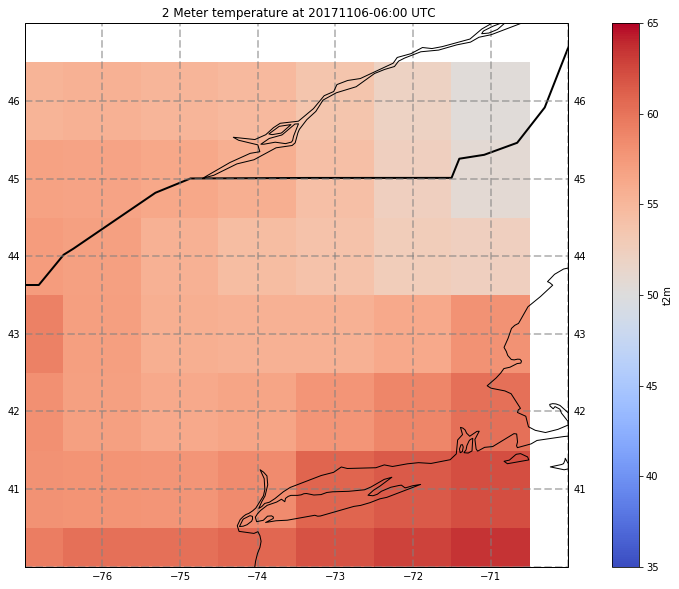

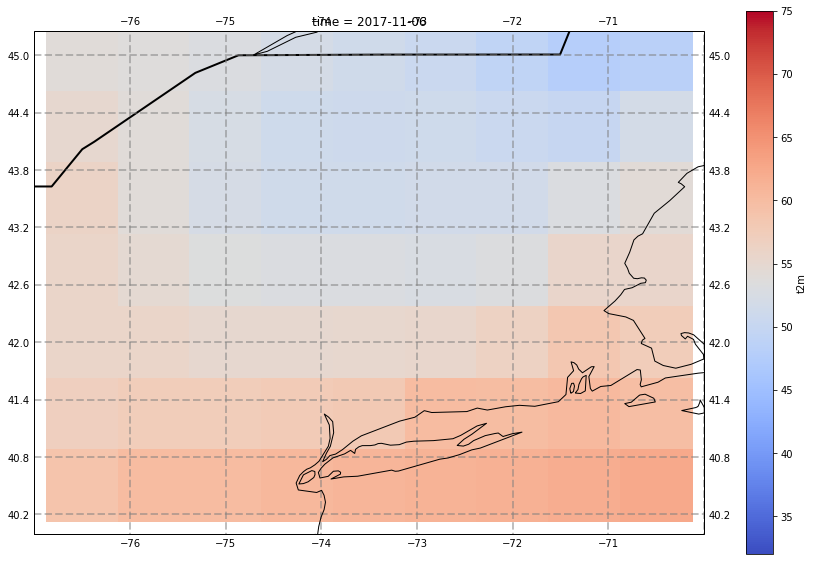

In [16]:
fig = plt.figure(figsize=(15., 10.))

proj = ccrs.PlateCarree()
ax = plt.axes(projection=proj)
myair.plot.pcolormesh(ax=ax, transform=proj,
                     vmin = 32, vmax = 75, cmap = 'coolwarm')

state_boundaries = feat.NaturalEarthFeature(category='cultural',
                                            name='admin_1_states_provinces_lines',
                                            scale='50m', facecolor='none')

ax.coastlines(resolution='50m', zorder=2, color='black')
ax.add_feature(state_boundaries)
ax.add_feature(feat.BORDERS, linewidth=2, edgecolor='black')
ax.set_extent(extent)
gl = ax.gridlines(crs=proj, draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

In [27]:
for i in range(len(foo.latitude)):
    for j in range(len(foo.longitude)):
        strg = "{lat},{lon},{t2}"
        print( strg.format(lat=foo.latitude[i].data, 
                          lon=foo.longitude[j].data,
                         t2=foo[i,j].data))

35.0,-84.0,66.90438842773438
35.0,-80.0,74.07334899902344
35.0,-76.0,72.00984191894531
35.0,-72.0,76.80372619628906
35.0,-68.0,75.32513427734375
39.0,-84.0,51.66722869873047
39.0,-80.0,56.61420822143555
39.0,-76.0,69.59378814697266
39.0,-72.0,69.43800354003906
39.0,-68.0,71.72557067871094
43.0,-84.0,44.148460388183594
43.0,-80.0,45.09410858154297
43.0,-76.0,48.37660598754883
43.0,-72.0,62.3892822265625
43.0,-68.0,58.3934440612793
47.0,-84.0,29.9526424407959
47.0,-80.0,29.47979164123535
47.0,-76.0,32.554588317871094
47.0,-72.0,41.18846893310547
47.0,-68.0,54.70099639892578


In [28]:
foo[1,1].data

array(56.61421, dtype=float32)

In [ ]:
foo.dims

In [ ]:
foo.time.data.strptime('%y')

In [11]:
d


'2017.11.07'

In [37]:
start_era = era.sel(time=era.time[0:40])

In [41]:
time = pd.date_range('2017-11-05', freq='4H', periods=10)

In [42]:
time

DatetimeIndex(['2017-11-05 00:00:00', '2017-11-05 04:00:00',
               '2017-11-05 08:00:00', '2017-11-05 12:00:00',
               '2017-11-05 16:00:00', '2017-11-05 20:00:00',
               '2017-11-06 00:00:00', '2017-11-06 04:00:00',
               '2017-11-06 08:00:00', '2017-11-06 12:00:00'],
              dtype='datetime64[ns]', freq='4H')

In [43]:
interp_era = era.interp(coords={'time': time})

In [45]:
interp_era.time

<xarray.DataArray 'time' (time: 10)>
array(['2017-11-05T00:00:00.000000000', '2017-11-05T04:00:00.000000000',
       '2017-11-05T08:00:00.000000000', '2017-11-05T12:00:00.000000000',
       '2017-11-05T16:00:00.000000000', '2017-11-05T20:00:00.000000000',
       '2017-11-06T00:00:00.000000000', '2017-11-06T04:00:00.000000000',
       '2017-11-06T08:00:00.000000000', '2017-11-06T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-11-05 2017-11-05T04:00:00 ...